# 查看根目录下需要运行的文件夹

In [1]:
from pathlib import Path

if __name__ == "__main__":
    # === 1) 给定一个根目录 ===
    root_dir = Path("/workspace/models/SAHI/run_v8")
    # end_with = "_sliced"
    end_with = "_data"

    # === 2) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("**/*" + end_with))


    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        exit(0)

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 3) 让你选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs
    
    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # 如果有的文件夹的raw_data里面没有图片，就移除
    chosen_dirs = [d for d in chosen_dirs if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))]
    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        exit(0)

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data
[1] /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data
[2] /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data
将处理以下 _data 目录：
- 1. /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data
- 2. /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data
- 3. /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data


# 0202 运行YOLO分割模型，给被分割的子图数据标记掩码


In [2]:
from ultralytics import YOLO
from pathlib import Path
import os, gc
import orjson as jsonlib
import torch

model = YOLO("/workspace/models/best_model/yolo11n-seg-best.pt")

# —— 推荐的统一参数（更省显存） ——
COMMON_KW = dict(
    imgsz=640,              # 比 640 更省显存；看精度再调
    conf=0.25,
    iou=0.45,
    device=0,               # '0' or 0 都行
    # stream=True,            # 流式
    batch=3,                # 2~4 之间找平衡
    retina_masks=False,     # 省显存
    workers=2,              # 降低 DataLoader 线程
    verbose=False,
    save=False,             # 不要额外保存可视化
)

_dumps = lambda obj: jsonlib.dumps(obj, option=jsonlib.OPT_INDENT_2 | jsonlib.OPT_NON_STR_KEYS)
_loads = jsonlib.loads

for d in chosen_dirs:
    print(f"\n=== 处理目录: {d} ===")
    src_dir = Path(str(d) + "_sliced")
    if not src_dir.exists() or not any(src_dir.iterdir()):
        print(f"跳过空目录: {src_dir}")
        continue

    # 可选：把目录分批（分片）处理，避免一次性挂太多文件到 DataLoader
    all_imgs = [p for p in src_dir.glob("*.jpg")] + [p for p in src_dir.glob("*.png")]
    if not all_imgs:
        print(f"无图片: {src_dir}")
        continue

    # 分片大小（按显存调整；几千张图就分片）
    CHUNK = 100
    for si in range(0, len(all_imgs), CHUNK):
        chunk = all_imgs[si:si+CHUNK]
        print(f" -> 分片 {si}-{si+len(chunk)-1} / {len(all_imgs)}")

        # 用流式预测 + 小 batch
        results_gen = model.predict(chunk, **COMMON_KW)

        # 逐条结果立刻落盘并释放
        for i, result in enumerate(results_gen, 1):
            try:
                det_list = _loads(result.to_json())

                h, w = map(int, result.orig_shape[:2])
                img_name = os.path.basename(getattr(result, "path", "")) or f"image_{i}.png"

                shapes = []
                for det in det_list:
                    seg = det.get("segments", {})
                    xs, ys = seg.get("x", []), seg.get("y", [])
                    if not xs or not ys:
                        continue
                    points = [[float(x), float(y)] for x, y in zip(xs, ys)]
                    shapes.append({
                        "label": det.get("name", ""),
                        "score": float(det.get("confidence", 0.0)),
                        "points": points,
                        "shape_type": "polygon",
                    })

                labelme_obj = {
                    "shapes": shapes,
                    "imagePath": img_name,
                    "imageHeight": h,
                    "imageWidth": w,
                }

                out_path = src_dir / f"{Path(img_name).stem}.json"
                out_path.write_bytes(_dumps(labelme_obj))

            finally:
                # 及时释放 GPU/CPU 内存
                del result
                if i % 64 == 0:  # 每 64 张清一次缓存（可酌情调整）
                    torch.cuda.empty_cache()
                    gc.collect()

        # 分片结束再清一次
        torch.cuda.empty_cache()
        gc.collect()

    print(f"✅ Done. Saved to: {src_dir}")


=== 处理目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data ===
 -> 分片 0-99 / 4158
 -> 分片 100-199 / 4158
 -> 分片 200-299 / 4158
 -> 分片 300-399 / 4158
 -> 分片 400-499 / 4158
 -> 分片 500-599 / 4158
 -> 分片 600-699 / 4158
 -> 分片 700-799 / 4158
 -> 分片 800-899 / 4158
 -> 分片 900-999 / 4158
 -> 分片 1000-1099 / 4158
 -> 分片 1100-1199 / 4158
 -> 分片 1200-1299 / 4158
 -> 分片 1300-1399 / 4158
 -> 分片 1400-1499 / 4158
 -> 分片 1500-1599 / 4158
 -> 分片 1600-1699 / 4158
 -> 分片 1700-1799 / 4158
 -> 分片 1800-1899 / 4158
 -> 分片 1900-1999 / 4158
 -> 分片 2000-2099 / 4158
 -> 分片 2100-2199 / 4158
 -> 分片 2200-2299 / 4158
 -> 分片 2300-2399 / 4158
 -> 分片 2400-2499 / 4158
 -> 分片 2500-2599 / 4158
 -> 分片 2600-2699 / 4158
 -> 分片 2700-2799 / 4158
 -> 分片 2800-2899 / 4158
 -> 分片 2900-2999 / 4158
 -> 分片 3000-3099 / 4158
 -> 分片 3100-3199 / 4158
 -> 分片 3200-3299 / 4158
 -> 分片 3300-3399 / 4158
 -> 分片 3400-3499 / 4158
 -> 分片 3500-3599 / 4158
 -> 分片 3600-3699 / 4158
 -> 分片 3700-3799 / 4158
 -> 分片 3800-3899 / 4158
 -> 分片 3900-3

# 0203  合并子图到大图。也将segmentation信息整合

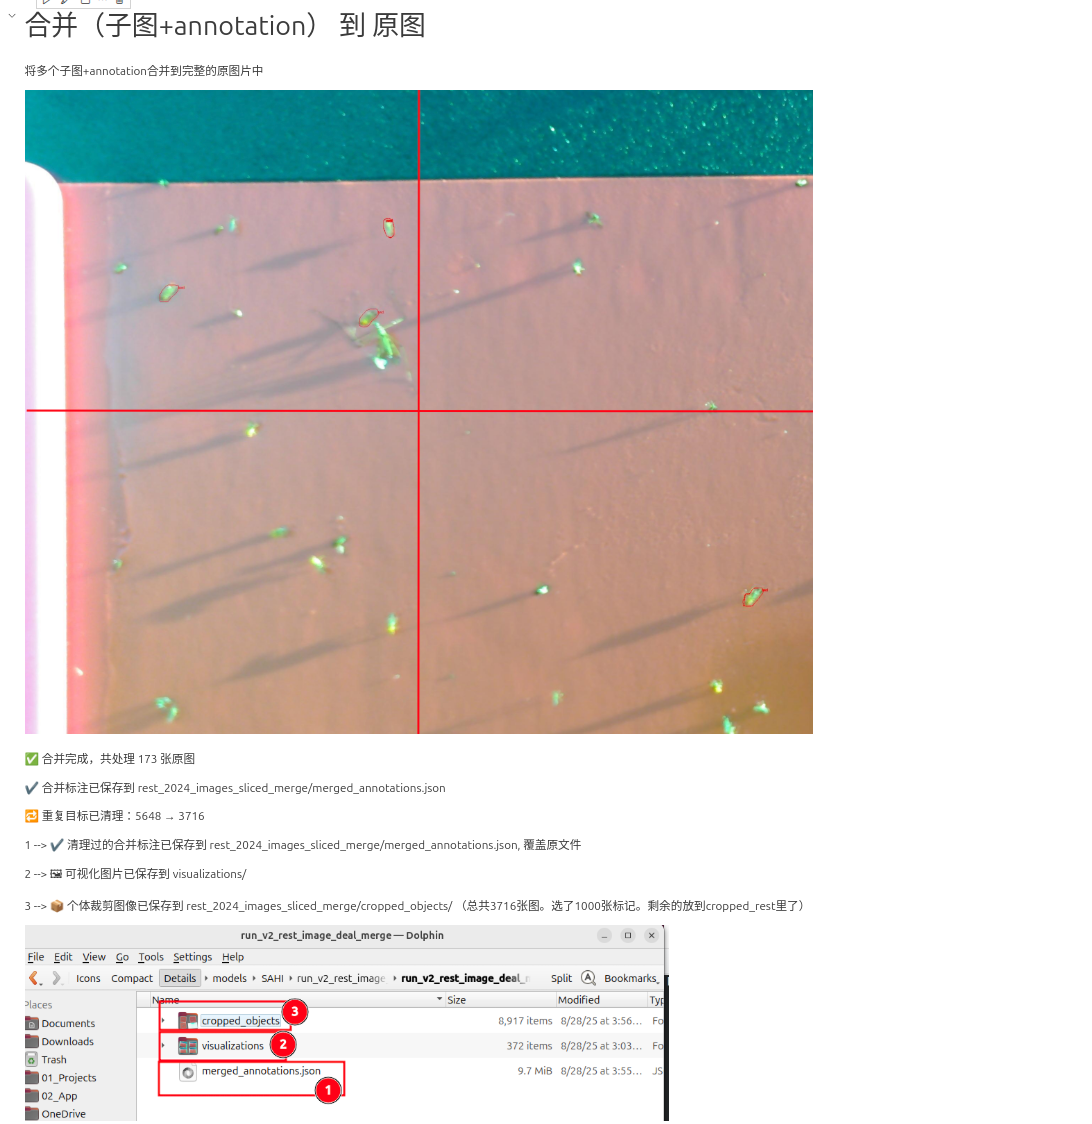

In [3]:
import os
import math
import uuid
from collections import defaultdict
from pathlib import Path
from typing import Optional, Iterable, List, Dict, Any, Tuple

import orjson
from tqdm import tqdm
import numpy as np
import cv2
from concurrent.futures import ProcessPoolExecutor, as_completed

# ============== JSON 封装（orjson） ==============
def json_load(path: str):
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def json_dump(obj, path: str):
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))


# ============== shapely（可选） ==============
try:
    from shapely.geometry import Polygon
    from shapely.ops import unary_union
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False


# ============== 工具：原图索引与绘制 ==============
def _build_image_index(original_image_dir: str) -> Dict[str, str]:
    """一次性建立 原图stem -> 绝对路径 的索引，避免每张图都 listdir。"""
    idx: Dict[str, str] = {}
    for p in Path(original_image_dir).glob("*.jpg"):
        idx[p.stem] = str(p)
    return idx

def _draw_one_image_cv2(args: Tuple[str, List[Dict[str, Any]], str, str, bool, int]) -> bool:
    """
    子进程：OpenCV 绘制多边形与可选文字，并保存 JPEG
    args = (image_name, annotations, image_path, out_dir, draw_text, jpeg_quality)
    """
    image_name, annotations, image_path, out_dir, draw_text, jpeg_quality = args
    img = cv2.imread(image_path)  # BGR
    if img is None:
        return False

    for ann in annotations:
        pts = np.asarray(ann["points"], dtype=np.int32).reshape(-1, 1, 2)
        # 多边形（黄色BGR=(0,255,255)）
        cv2.polylines(img, [pts], isClosed=True, thickness=1, color=(0, 255, 255))

        if draw_text:
            label = ann.get("label", "")
            score = float(ann.get("score", 0.0))
            x0, y0 = int(ann["points"][0][0]) + 12, int(ann["points"][0][1]) + 12
            txt = f"{label} {score:.3f}"
            # 黑底 + 黄色字
            cv2.putText(img, txt, (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.putText(img, txt, (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)

    out_path = os.path.join(out_dir, f"{image_name}_vis.jpg")
    cv2.imwrite(out_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])
    return True


# ============== 解析切片文件名 ==============
def parse_filename(filename: str):
    """解析切片文件名获取原图名和偏移（..._x1_y1_x2_y2）"""
    parts = Path(filename).stem.split("_")
    name = "_".join(parts[:-4])
    x1, y1, x2, y2 = map(int, parts[-4:])
    return name, x1, y1


# ============== 合并所有切片标注 ==============
def merge_annotations(sliced_label_dir: str, output_json_path: str) -> Dict[str, List[Dict[str, Any]]]:
    merged_annotations: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    json_files = list(Path(sliced_label_dir).rglob("*.json"))

    for json_file in tqdm(json_files, desc="Merging JSON", unit="file"):
        data = json_load(str(json_file))
        image_path = data["imagePath"]
        original_name, offset_x, offset_y = parse_filename(image_path)
        for shape in data.get("shapes", []):
            points = shape["points"]
            label = shape.get("label", "")
            new_points = [[x + offset_x, y + offset_y] for x, y in points]
            merged_annotations[original_name].append({
                "uuid": str(uuid.uuid4()),
                "original_name": original_name,
                "label": label,
                "points": new_points,
                "offset_x": offset_x,
                "offset_y": offset_y,
                "score": float(shape.get("score", 0.0)),
            })

    json_dump(merged_annotations, output_json_path)
    print(f"✅ 合并完成，共处理 {len(merged_annotations)} 张原图")
    print(f"✔️ 合并标注已保存到 {output_json_path}")
    return merged_annotations


# ============== 后处理去重（NMS/GREEDYNMM/NMM/LSNMS） ==============
def remove_duplicate_annotations(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    output_json_path: str,
    postprocess_type: str = "GREEDYNMM",           # 'NMM' | 'GREEDYNMM' | 'LSNMS' | 'NMS'
    postprocess_match_metric: str = "IOS",         # 'IOU' | 'IOS'
    postprocess_match_threshold: float = 0.5,
    postprocess_class_agnostic: bool = False,
    center_thresh: Optional[float] = 20.0,
    keep_mode: str = "REP"                         # 'REP' or 'UNION_POLY'
) -> Dict[str, List[Dict[str, Any]]]:

    def polygon_to_bbox(points: Iterable[Iterable[float]]) -> List[float]:
        xs, ys = zip(*points)
        return [min(xs), min(ys), max(xs), max(ys)]

    def bbox_area(b):
        w = b[2] - b[0]; h = b[3] - b[1]
        return (w if w > 0 else 0) * (h if h > 0 else 0)

    def bbox_iou(A, B):
        xA = max(A[0], B[0]); yA = max(A[1], B[1])
        xB = min(A[2], B[2]); yB = min(A[3], B[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0: return 0.0
        u = bbox_area(A) + bbox_area(B) - inter
        return inter / u if u > 0 else 0.0

    def bbox_ios(A, B):
        xA = max(A[0], B[0]); yA = max(A[1], B[1])
        xB = min(A[2], B[2]); yB = min(A[3], B[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0: return 0.0
        smaller = min(bbox_area(A), bbox_area(B))
        return inter / smaller if smaller > 0 else 0.0

    def center_distance(A, B):
        cxA = (A[0] + A[2]) * 0.5; cyA = (A[1] + A[3]) * 0.5
        cxB = (B[0] + B[2]) * 0.5; cyB = (B[1] + B[3]) * 0.5
        return math.hypot(cxA - cxB, cyA - cyB)

    match_metric = bbox_iou if postprocess_match_metric.upper() == "IOU" else bbox_ios

    def same_group(ann_i: Dict, ann_j: Dict) -> bool:
        if (not postprocess_class_agnostic) and (ann_i["label"] != ann_j["label"]):
            return False
        bi = polygon_to_bbox(ann_i["points"])
        bj = polygon_to_bbox(ann_j["points"])
        if (center_thresh is not None) and center_distance(bi, bj) > center_thresh:
            return False
        return match_metric(bi, bj) >= postprocess_match_threshold

    def safe_score(a: Dict) -> float:
        try:
            return float(a.get("score", 0.0))
        except Exception:
            return 0.0

    def choose_rep_polygon_by_score(grp: List[Dict]) -> Dict:
        best = None
        best_key = (-1e9, -1e9)  # (score, overlap_sum)
        for i, ai in enumerate(grp):
            bi = polygon_to_bbox(ai["points"])
            overlap_sum = 0.0
            for j, aj in enumerate(grp):
                if i == j: continue
                overlap_sum += match_metric(bi, polygon_to_bbox(aj["points"]))
            key = (safe_score(ai), overlap_sum)
            if key > best_key:
                best_key = key; best = ai
        rep = dict(best)
        rep["uuid"] = str(uuid.uuid4())
        return rep

    def union_polygon(grp: List[Dict]) -> Dict:
        if not _HAVE_SHAPELY:
            return choose_rep_polygon_by_score(grp)
        polys = []
        for a in grp:
            pts = a["points"]
            if len(pts) >= 3:
                try:
                    polys.append(Polygon(pts))
                except Exception:
                    pass
        if not polys:
            return choose_rep_polygon_by_score(grp)
        merged = unary_union(polys)
        if merged.geom_type == "MultiPolygon":
            merged = max(list(merged.geoms), key=lambda p: p.area)
        xys = list(merged.exterior.coords)[:-1]
        base = dict(grp[0])
        base["uuid"] = str(uuid.uuid4())
        base["points"] = [[float(x), float(y)] for (x, y) in xys] or grp[0]["points"]
        base["score"] = max(safe_score(a) for a in grp)
        return base

    def merge_group(grp: List[Dict]) -> Dict:
        return union_polygon(grp) if keep_mode.upper() == "UNION_POLY" else choose_rep_polygon_by_score(grp)

    def nms_by_score(anns: List[Dict]) -> List[Dict]:
        anns_sorted = sorted(anns, key=lambda a: safe_score(a), reverse=True)
        keep: List[Dict] = []
        for a in anns_sorted:
            suppress = False
            ba = None
            for b in keep:
                if (not postprocess_class_agnostic) and a["label"] != b["label"]:
                    continue
                if ba is None:
                    ba = [*map(min, zip(*a["points"]))]  # lazy bbox计算（但下面更安全算一次）
                    ba = polygon_to_bbox(a["points"])
                bb = polygon_to_bbox(b["points"])
                if (center_thresh is None or center_distance(ba, bb) <= center_thresh) and \
                   match_metric(ba, bb) >= postprocess_match_threshold:
                    suppress = True; break
            if not suppress:
                keep.append(a)
        out = []
        for k in keep:
            kk = dict(k); kk["uuid"] = str(uuid.uuid4())
            out.append(kk)
        return out

    def greedy_group_by_score(anns: List[Dict]) -> List[List[Dict]]:
        used = [False] * len(anns)
        order = sorted(range(len(anns)), key=lambda i: safe_score(anns[i]), reverse=True)
        groups: List[List[Dict]] = []
        for idx in order:
            if used[idx]: continue
            seed = anns[idx]
            grp = [seed]; used[idx] = True
            changed = True
            while changed:
                changed = False
                for j, aj in enumerate(anns):
                    if used[j]: continue
                    if any(same_group(aj, g) for g in grp):
                        grp.append(aj); used[j] = True; changed = True
            groups.append(grp)
        return groups

    def pairwise_group(anns: List[Dict]) -> List[List[Dict]]:
        used = [False] * len(anns)
        groups: List[List[Dict]] = []
        order = sorted(range(len(anns)), key=lambda i: safe_score(anns[i]), reverse=True)
        for idx in order:
            if used[idx]: continue
            seed = anns[idx]
            grp = [seed]; used[idx] = True
            for j in order:
                if used[j]: continue
                if same_group(seed, anns[j]):
                    grp.append(anns[j]); used[j] = True
            groups.append(grp)
        return groups

    def lsnms_like(anns: List[Dict]) -> List[Dict]:
        anns_sorted = sorted(anns, key=lambda a: safe_score(a), reverse=True)
        kept_reps: List[Dict] = []
        suppressed = [False] * len(anns_sorted)
        for i, ai in enumerate(anns_sorted):
            if suppressed[i]: continue
            group = [ai]; suppressed[i] = True
            bai = polygon_to_bbox(ai["points"])
            for j in range(i + 1, len(anns_sorted)):
                if suppressed[j]: continue
                aj = anns_sorted[j]
                if (not postprocess_class_agnostic) and (ai["label"] != aj["label"]):
                    continue
                baj = polygon_to_bbox(aj["points"])
                if (center_thresh is None or center_distance(bai, baj) <= center_thresh) and \
                   match_metric(bai, baj) >= postprocess_match_threshold:
                    group.append(aj); suppressed[j] = True
            kept_reps.append(merge_group(group))
        return kept_reps

    cleaned_annotations: Dict[str, List[Dict]] = {}
    total_before = sum(len(v) for v in merged_annotations.values())
    total_after = 0

    for image_name, ann_list in tqdm(merged_annotations.items(), desc="Postprocessing", unit="image"):
        if not postprocess_class_agnostic:
            buckets = defaultdict(list)
            for a in ann_list:
                buckets[a["label"]].append(a)
            out_list: List[Dict] = []
            for _, bucket in buckets.items():
                t = postprocess_type.upper()
                if t == "NMS":
                    out_list.extend(nms_by_score(bucket))
                elif t == "NMM":
                    out_list.extend(merge_group(g) for g in pairwise_group(bucket))
                elif t == "LSNMS":
                    out_list.extend(lsnms_like(bucket))
                else:  # GREEDYNMM
                    out_list.extend(merge_group(g) for g in greedy_group_by_score(bucket))
        else:
            t = postprocess_type.upper()
            if t == "NMS":
                out_list = nms_by_score(ann_list)
            elif t == "NMM":
                out_list = [merge_group(g) for g in pairwise_group(ann_list)]
            elif t == "LSNMS":
                out_list = lsnms_like(ann_list)
            else:
                out_list = [merge_group(g) for g in greedy_group_by_score(ann_list)]

        cleaned_annotations[image_name] = out_list
        total_after += len(out_list)

    json_dump(cleaned_annotations, output_json_path)

    print(f"🔁 后处理完成（{postprocess_type}, metric={postprocess_match_metric}, thr={postprocess_match_threshold}, class_agnostic={postprocess_class_agnostic}, keep={keep_mode}）")
    print(f"    目标数：{total_before} → {total_after}")
    if keep_mode.upper() == "UNION_POLY" and not _HAVE_SHAPELY:
        print("⚠️ 未检测到 shapely，已自动退回 keep_mode='REP'。想要 polygon 并集，请： pip install shapely")
    print(f"✔️ 已保存到 {output_json_path}（覆盖）")
    return cleaned_annotations


# ============== 可视化（OpenCV 并行） ==============
def visualize_annotations(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    original_image_dir: str,
    output_visual_dir: str,
    draw_text: bool = True,
    jpeg_quality: int = 85,
    parallel: bool = True,
    max_workers: Optional[int] = None
):
    os.makedirs(output_visual_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    tasks: List[Tuple] = []
    for image_name, annotations in merged_annotations.items():
        image_path = image_index.get(image_name)
        if image_path is None or not os.path.exists(image_path):
            # 兜底：前缀匹配（只在 miss 时触发）
            found = None
            for p in Path(original_image_dir).glob(f"{image_name}*.jpg"):
                found = str(p); break
            image_path = found
        if image_path is None or not os.path.exists(image_path):
            continue
        tasks.append((image_name, annotations, image_path, output_visual_dir, draw_text, jpeg_quality))

    if not tasks:
        print("⚠️ 没有可视化任务（未匹配到原图）")
        return

    if not parallel:
        for t in tqdm(tasks, desc="Visualizing (serial)", unit="image"):
            _draw_one_image_cv2(t)
    else:
        if max_workers is None:
            max_workers = max(2, (os.cpu_count() or 8) // 2)
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            futures = [ex.submit(_draw_one_image_cv2, t) for t in tasks]
            for _ in tqdm(as_completed(futures), total=len(futures), desc="Visualizing (parallel)", unit="image"):
                pass

    print(f"🖼 可视化图片已保存到 {output_visual_dir}/")


# ============== 裁剪导出（OpenCV 并行） ==============
def _export_one_image_objects_cv2(args: Tuple[str, List[Dict[str, Any]], str, str, int, int]) -> int:
    """
    子进程：按照 polygon 的外接正方形裁剪并保存（带 margin）
    args = (image_name, annotations, image_path, out_dir, margin, jpeg_quality)
    """
    image_name, annotations, image_path, out_dir, margin, jpeg_quality = args
    img = cv2.imread(image_path)
    if img is None:
        return 0
    H, W = img.shape[:2]
    saved = 0

    for idx, ann in enumerate(annotations):
        pts = np.asarray(ann["points"], dtype=np.float32)
        xs = pts[:, 0]; ys = pts[:, 1]
        min_x, max_x = float(xs.min()), float(xs.max())
        min_y, max_y = float(ys.min()), float(ys.max())

        width  = max_x - min_x
        height = max_y - min_y
        side   = max(width, height)

        cx = (min_x + max_x) * 0.5
        cy = (min_y + max_y) * 0.5

        left   = int(round(cx - side * 0.5)) - margin
        top    = int(round(cy - side * 0.5)) - margin
        right  = int(round(cx + side * 0.5)) + margin
        bottom = int(round(cy + side * 0.5)) + margin

        left   = max(0, left)
        top    = max(0, top)
        right  = min(W, right)
        bottom = min(H, bottom)

        if right - left <= 1 or bottom - top <= 1:
            continue

        crop = img[top:bottom, left:right]
        save_name = f"{image_name}_obj{idx}_{ann.get('label','')}_uuid_{ann['uuid']}.jpg"
        out_path = os.path.join(out_dir, save_name)
        cv2.imwrite(out_path, crop, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])
        saved += 1

    return saved


def export_individual_objects_cv2(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    original_image_dir: str,
    cropped_object_dir: str,
    margin: int = 0,
    jpeg_quality: int = 85,
    parallel: bool = True,
    max_workers: Optional[int] = None
):
    os.makedirs(cropped_object_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    tasks: List[Tuple] = []
    for image_name, annotations in merged_annotations.items():
        image_path = image_index.get(image_name)
        if image_path is None or not os.path.exists(image_path):
            found = None
            for p in Path(original_image_dir).glob(f"{image_name}*.jpg"):
                found = str(p); break
            image_path = found
        if image_path is None or not os.path.exists(image_path):
            continue
        tasks.append((image_name, annotations, image_path, cropped_object_dir, margin, jpeg_quality))

    total = 0
    if not tasks:
        print("⚠️ 没有可导出的裁剪任务（未匹配到原图）")
        return

    if not parallel:
        for t in tqdm(tasks, desc="Exporting crops (serial)", unit="image"):
            total += _export_one_image_objects_cv2(t)
    else:
        if max_workers is None:
            max_workers = max(2, (os.cpu_count() or 8) // 2)
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            futures = [ex.submit(_export_one_image_objects_cv2, t) for t in tasks]
            for fut in tqdm(as_completed(futures), total=len(futures), desc="Exporting crops (parallel)", unit="image"):
                total += fut.result()

    print(f"📦 个体裁剪图像已保存到 {cropped_object_dir}/ （共导出 {total} 张）")

In [4]:
if __name__ == "__main__":
    for d in chosen_dirs:
        print(f"\n=== 处理目录: {d} ===")
        original_image_dir = str(d)
        sliced_label_dir = str(d) + "_sliced"
        output_json_path = str(d) + "_sliced_merge/merged_annotations.json"
        output_visual_dir = str(d) + "_sliced_merge/visualizations"
        cropped_object_dir = str(d) + "_sliced_merge/cropped_objects"

        print(f"原图目录: {original_image_dir}")
        print(f"切片标注目录: {sliced_label_dir}")
        print(f"输出合并标注: {output_json_path}")
        print(f"输出可视化目录: {output_visual_dir}")
        print(f"输出裁剪目录: {cropped_object_dir}")

        os.makedirs(output_visual_dir, exist_ok=True)
        os.makedirs(cropped_object_dir, exist_ok=True)

        # 1) 合并
        merged_annotations = merge_annotations(sliced_label_dir, output_json_path)

        # 2) 后处理（按需切换 NMS / GREEDYNMM / NMM / LSNMS；IOS/IOU；REP/UNION_POLY）
        merged_annotations = remove_duplicate_annotations(
            merged_annotations,
            output_json_path,
            postprocess_type="NMS",           # 'NMM'/'GREEDYNMM'/'LSNMS'/'NMS'
            postprocess_match_metric="IOS",   # 'IOU' or 'IOS'
            postprocess_match_threshold=0.5,
            postprocess_class_agnostic=False,
            center_thresh=20,
            keep_mode="REP"                   # or "UNION_POLY"（需 shapely）
        )

        # 3) 可视化（OpenCV 并行）
        visualize_annotations(
            merged_annotations,
            original_image_dir,
            output_visual_dir,
            draw_text=True,          # 关掉更快
            jpeg_quality=85,         # 75~85 够用
            parallel=True,
            max_workers=None
        )

        # 4) 导出裁剪（OpenCV 并行）
        export_individual_objects_cv2(
            merged_annotations,
            original_image_dir,
            cropped_object_dir,
            margin=15,
            jpeg_quality=85,
            parallel=True,
            max_workers=None
        )


=== 处理目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data ===
原图目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data
切片标注目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced
输出合并标注: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/merged_annotations.json
输出可视化目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/visualizations
输出裁剪目录: /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/cropped_objects


Merging JSON: 100%|██████████| 4158/4158 [00:05<00:00, 829.53file/s] 


✅ 合并完成，共处理 66 张原图
✔️ 合并标注已保存到 /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/merged_annotations.json


Postprocessing: 100%|██████████| 66/66 [00:00<00:00, 5155.20image/s]


🔁 后处理完成（NMS, metric=IOS, thr=0.5, class_agnostic=False, keep=REP）
    目标数：1135 → 822
✔️ 已保存到 /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/merged_annotations.json（覆盖）


Visualizing (parallel): 100%|██████████| 66/66 [00:02<00:00, 28.31image/s]


🖼 可视化图片已保存到 /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/visualizations/


Exporting crops (parallel): 100%|██████████| 66/66 [00:00<00:00, 70.06image/s]


📦 个体裁剪图像已保存到 /workspace/models/SAHI/run_v8/autofocus_picamera2/raw_data_sliced_merge/cropped_objects/ （共导出 822 张）

=== 处理目录: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data ===
原图目录: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data
切片标注目录: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced
输出合并标注: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json
输出可视化目录: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/visualizations
输出裁剪目录: /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/cropped_objects


Merging JSON: 100%|██████████| 7560/7560 [00:08<00:00, 917.64file/s] 


✅ 合并完成，共处理 30 张原图
✔️ 合并标注已保存到 /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json


Postprocessing: 100%|██████████| 30/30 [00:00<00:00, 2443.95image/s]

🔁 后处理完成（NMS, metric=IOS, thr=0.5, class_agnostic=False, keep=REP）
    目标数：658 → 534
✔️ 已保存到 /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json（覆盖）



Visualizing (parallel): 100%|██████████| 30/30 [00:04<00:00,  7.28image/s]


🖼 可视化图片已保存到 /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/visualizations/


Exporting crops (parallel): 100%|██████████| 30/30 [00:01<00:00, 23.62image/s]


📦 个体裁剪图像已保存到 /workspace/models/SAHI/run_v8/autofocus_rpicam_still/raw_data_sliced_merge/cropped_objects/ （共导出 534 张）

=== 处理目录: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data ===
原图目录: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data
切片标注目录: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced
输出合并标注: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json
输出可视化目录: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/visualizations
输出裁剪目录: /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/cropped_objects


Merging JSON: 100%|██████████| 7560/7560 [00:06<00:00, 1141.24file/s]


✅ 合并完成，共处理 30 张原图
✔️ 合并标注已保存到 /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json


Postprocessing: 100%|██████████| 30/30 [00:00<00:00, 2931.58image/s]

🔁 后处理完成（NMS, metric=IOS, thr=0.5, class_agnostic=False, keep=REP）
    目标数：613 → 497
✔️ 已保存到 /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/merged_annotations.json（覆盖）



Visualizing (parallel): 100%|██████████| 30/30 [00:03<00:00,  8.46image/s]

🖼 可视化图片已保存到 /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/visualizations/



Exporting crops (parallel): 100%|██████████| 30/30 [00:01<00:00, 26.12image/s]


📦 个体裁剪图像已保存到 /workspace/models/SAHI/run_v8/manualfocus_rpicam_still/raw_data_sliced_merge/cropped_objects/ （共导出 497 张）


# 0301 跑分类模型

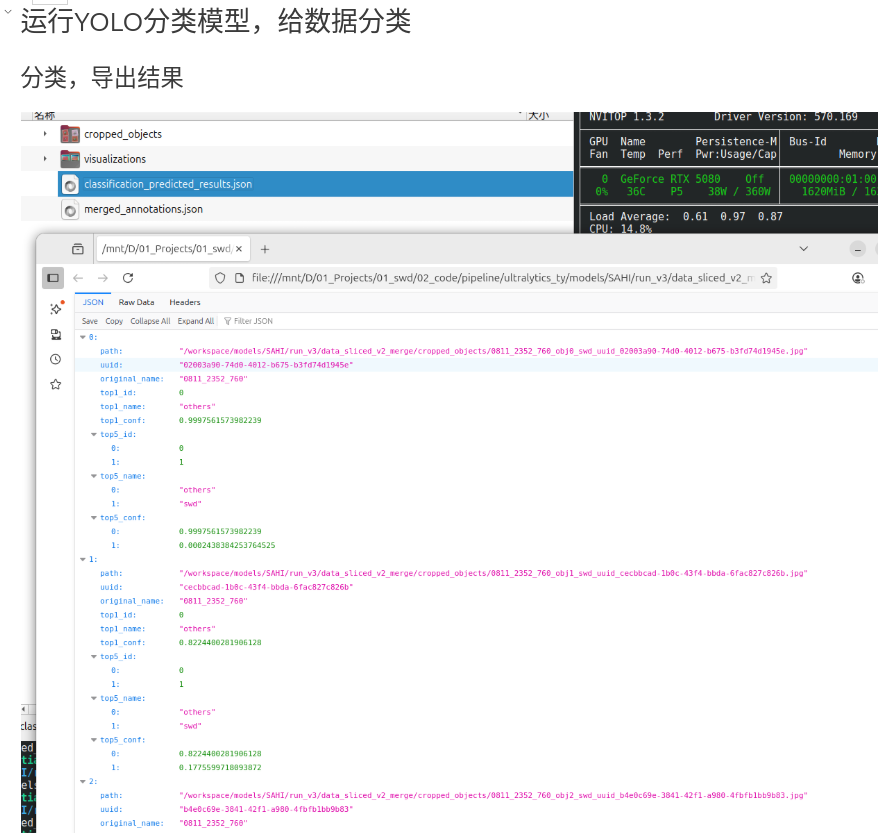

In [ ]:
import os
import re
import json
from collections import Counter
from ultralytics import YOLO
from pathlib import Path


MODEL_PATH = "/workspace/models/best_model/yolo11n-cls-best_v5.pt"

# 解析文件名的正则表达式
UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.jpg", re.IGNORECASE)
ORIG_RE = re.compile(r"^(\d+_\d+_\d+)_obj", re.IGNORECASE)

def get_probs_fields(res, name_map):
    """安全获取 top1/top5 字段（缺失时给空值/空列表）。"""
    probs = getattr(res, "probs", None)
    if probs is None:
        return None, None, None, [], [], []

    # top1
    try:
        top1_id = int(probs.top1)
    except Exception:
        top1_id = None
    top1_name = name_map.get(top1_id) if top1_id is not None else None

    # top1 conf
    try:
        top1_conf = float(getattr(probs.top1conf, "item", lambda: probs.top1conf)())
    except Exception:
        top1_conf = None

    # top5
    try:
        top5_id = [int(x) for x in list(probs.top5)]
    except Exception:
        top5_id = []
    top5_name = [name_map.get(i, str(i)) for i in top5_id]
    try:
        top5_conf = [float(x) for x in list(probs.top5conf)]
    except Exception:
        top5_conf = []

    return top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf


# ==== 主流程 ====
if __name__ == "__main__":
    # 1) 加载模型
    model = YOLO(MODEL_PATH)
    class_names = model.names  # dict: {0: "...", 1: "..."}

    for d in chosen_dirs:
        print(f"\n=== 处理目录: {d} ===")
        input_dir  = str(d) + "_sliced_merge/cropped_objects/"
        output_json = str(d) + "_sliced_merge/classification_predicted_results.json"

        # 确保输入目录不为空
        if not any(Path(input_dir).glob("*.jpg")):
            print(f"⚠️ 输入目录 {input_dir} 没有 JPG 文件，跳过")
            continue

        # 2) 执行预测（Ultralytics 支持目录）
        results = model(input_dir)

        data = []
        counts = Counter()

        for res in results:
            path = getattr(res, "path", "")
            fname = os.path.basename(path)

            # 提取 uuid / 原图名
            uuid_match = UUID_RE.search(fname)
            uuid_str = uuid_match.group(1) if uuid_match else None
            orig_match = ORIG_RE.match(fname)
            original_name = orig_match.group(1) if orig_match else None

            # 概率字段
            top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf = get_probs_fields(res, class_names)
            if top1_id is not None:
                counts[top1_id] += 1

            # 记录一条
            data.append({
                "path": path,
                "uuid": uuid_str,
                "original_name": original_name,
                "top1_id": top1_id,
                "top1_name": top1_name,
                "top1_conf": top1_conf,
                "top5_id": top5_id,
                "top5_name": top5_name,
                "top5_conf": top5_conf,
            })

        # 3) 打印统计
        print("分类统计结果：")
        for cls_id, num in counts.items():
            print(f"{class_names.get(cls_id, cls_id)}: {num}")
        total = sum(counts.values())
        print(f"总计: {total}")

        # 4) 保存 JSON（保持与你原来一致的结构）
        with open(output_json, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)

        print(f"✅ 已保存到 {output_json}")


# 0302 根据分类结果，过滤错误数据

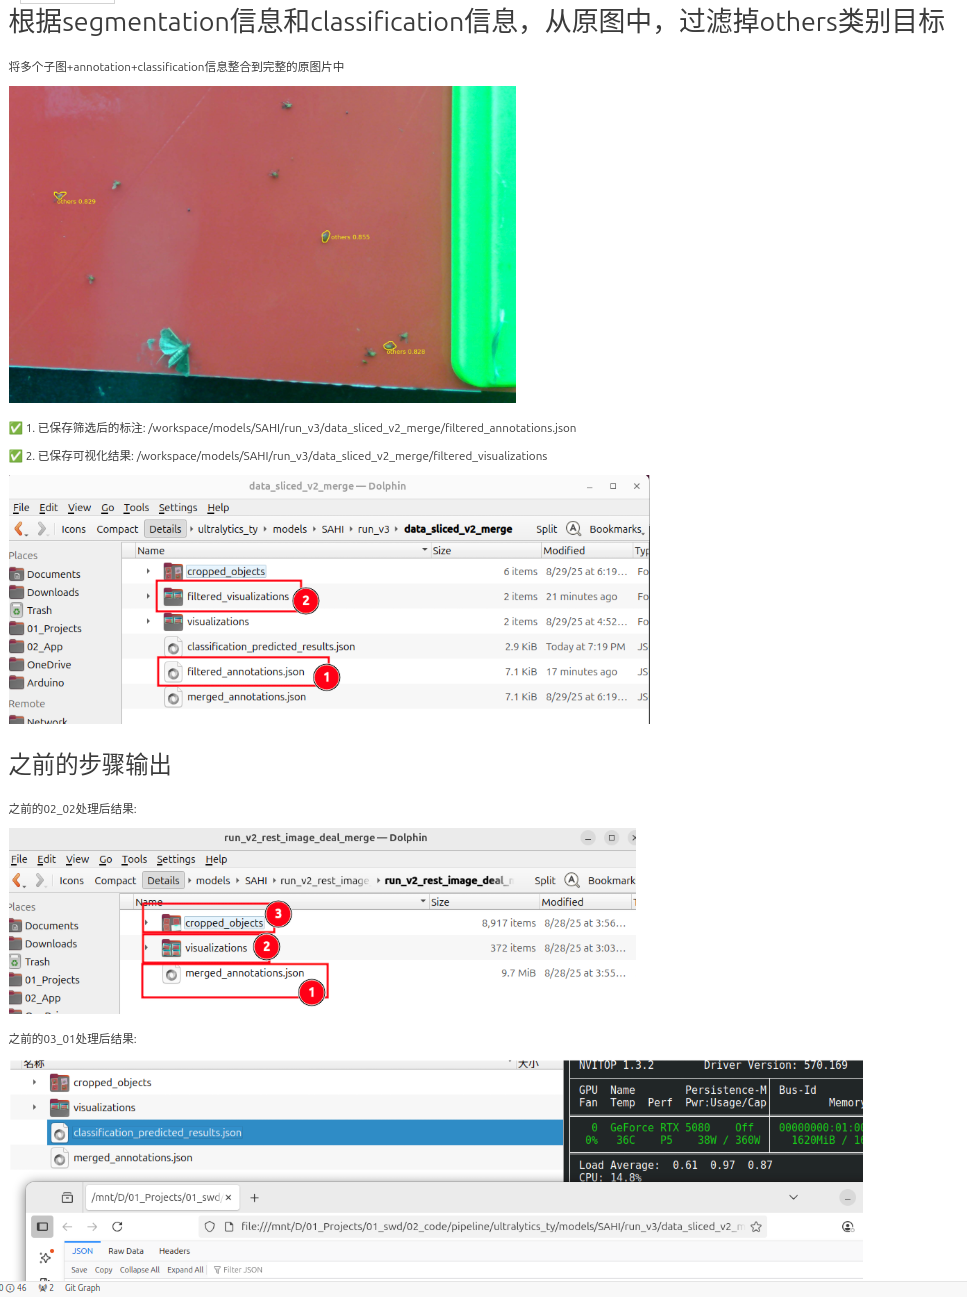

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import shutil
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import cv2
import numpy as np
import orjson
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from tqdm import tqdm
from collections import Counter

# ========= JSON I/O =========
def jload(fp: Path):
    with fp.open("rb") as f:
        return orjson.loads(f.read())

def jdump_to_file(obj, fp: Path):
    fp.parent.mkdir(parents=True, exist_ok=True)
    with fp.open("wb") as f:
        f.write(orjson.dumps(obj))

# ========= 工具函数 =========
def load_cls_map(path: Path) -> Dict[str, Dict]:
    """
    读取分类结果，返回 uuid -> item 的映射。
    允许两种结构：
    1) {"results": [...]}
    2) [ ... ]
    item 至少应包含: {"uuid": "...", "top1_name": "...",  ...}
    """
    data = jload(path)
    if isinstance(data, dict) and "results" in data:
        items = data["results"]
    elif isinstance(data, list):
        items = data
    else:
        raise ValueError("classification_predicted_results.json 结构不支持")
    return {it["uuid"]: it for it in items if "uuid" in it}

def build_image_index(img_dir: Path) -> Dict[str, Path]:
    index: Dict[str, Path] = {}
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        for p in img_dir.glob(ext):
            index[p.stem] = p
    return index

def filter_annotations(
    merged_annotations: Dict[str, List[dict]],
    cls_map: Dict[str, dict],
    keep: Optional[List[str]],
    drop: Optional[List[str]],
    relabel: bool
) -> Tuple[Dict[str, List[dict]], Tuple[int, int, int]]:
    out: Dict[str, List[dict]] = {}
    kept = dropped = not_found = 0
    keep_set = set(keep) if keep else None
    drop_set = set(drop) if drop else None

    for img, anns in tqdm(merged_annotations.items(), desc="筛选标注中", ncols=80):
        new_list: List[dict] = []
        for ann in anns:
            u = ann.get("uuid")
            if not u:
                continue
            pred = cls_map.get(u)
            if pred is None:
                not_found += 1
                continue

            top1 = pred.get("top1_name")
            if keep_set is not None and top1 not in keep_set:
                dropped += 1
                continue
            if drop_set is not None and top1 in drop_set:
                dropped += 1
                continue

            if relabel and top1:
                ann2 = dict(ann)
                ann2["label"] = top1
                new_list.append(ann2)
            else:
                new_list.append(ann)
            kept += 1

        if new_list:
            out[img] = new_list

    return out, (kept, dropped, not_found)

# ========= 可视化 =========
LINE_COLOR_BGR = (0, 255, 255)
LINE_WIDTH = 1
TEXT_SCALE = 0.7
TEXT_THICKNESS = 2
TEXT_COLOR_BGR = (0, 255, 255)
TEXT_FONT = cv2.FONT_HERSHEY_SIMPLEX
TEXT_DY = 18

def _draw_one_image(image_name: str, anns: List[dict], img_index: Dict[str, str], out_dir: str):
    img_path = img_index.get(image_name) or img_index.get(Path(image_name).stem)
    if not img_path:
        return None
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        return None

    for i, ann in enumerate(anns):
        pts = ann["points"]
        pts_np = np.asarray(pts, dtype=np.int32).reshape(-1, 1, 2)
        cv2.polylines(img, [pts_np], True, LINE_COLOR_BGR, LINE_WIDTH)

        label = str(ann.get("label", ""))
        s = ann.get("score")
        label_txt = f"{label} {s:.3f}" if isinstance(s, (float, int)) else label
        x0, y0 = int(pts[0][0]), int(pts[0][1])
        cv2.putText(img, label_txt, (x0 + 6, y0 + 6 + (i % 3) * TEXT_DY),
                    TEXT_FONT, TEXT_SCALE, TEXT_COLOR_BGR, TEXT_THICKNESS, cv2.LINE_AA)

    out_path = str(Path(out_dir) / f"{Path(image_name).stem}_vis.jpg")
    cv2.imwrite(out_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
    return out_path

def visualize_parallel(annotations: Dict[str, List[dict]], original_dir: Path, out_dir: Path, max_workers: int):
    out_dir.mkdir(parents=True, exist_ok=True)
    img_index = {k: str(v) for k, v in build_image_index(original_dir).items()}
    total = len(annotations)
    if total == 0:
        return
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [
            ex.submit(_draw_one_image, image_name, anns, img_index, str(out_dir))
            for image_name, anns in annotations.items()
        ]
        for _ in tqdm(as_completed(futures), total=total, desc="可视化中", ncols=80):
            pass

# ========= 小图整理（含 others）=========
_UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

def sort_cropped_objects(
    cropped_dir: Path,
    out_root: Path,
    cls_map: Dict[str, dict],
    keep: Optional[List[str]],
    drop: Optional[List[str]],
    max_workers: int
) -> Tuple[int, int, int, int, Counter]:
    """
    将 cropped_objects 里的图片按 top1_name 归类复制到 out_root/<class_name>/ 下，
    未命中 keep/drop 或无预测 / 文件名不匹配的，统一放到 out_root/others/ 下。
    返回: (总文件数, 符合条件复制数, 无预测数, others数, 各类别计数)
    """
    if not cropped_dir.exists():
        print(f"⚠️ 未找到裁剪目录: {cropped_dir}")
        return 0, 0, 0, 0, Counter()

    files: List[Path] = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        files.extend(cropped_dir.glob(ext))
    total = len(files)
    if total == 0:
        print(f"⚠️ 裁剪目录为空: {cropped_dir}")
        return 0, 0, 0, 0, Counter()

    copied_kept = 0
    no_pred = 0
    others = 0
    per_class = Counter()
    keep_set = set(keep) if keep else None
    drop_set = set(drop) if drop else None

    def to_dir(d: Path):
        d.mkdir(parents=True, exist_ok=True)
        return d

    def task(path: Path):
        nonlocal copied_kept, no_pred, others
        m = _UUID_RE.search(path.name)
        if not m:
            # 文件名不符合规则 → others
            dst = to_dir(out_root / "others")
            shutil.copy2(path, dst / path.name)
            per_class.update(["others"])
            others += 1
            return

        uuid = m.group(1)
        pred = cls_map.get(uuid)
        if pred is None:
            # 无预测 → others
            dst = to_dir(out_root / "others")
            shutil.copy2(path, dst / path.name)
            per_class.update(["others"])
            others += 1
            no_pred += 1
            return

        top1 = pred.get("top1_name")
        # 规则判断
        if keep_set is not None and top1 not in keep_set:
            dst = to_dir(out_root / "others")
            shutil.copy2(path, dst / path.name)
            per_class.update(["others"])
            others += 1
            return
        if drop_set is not None and top1 in drop_set:
            dst = to_dir(out_root / "others")
            shutil.copy2(path, dst / path.name)
            per_class.update(["others"])
            others += 1
            return

        # ✅ 符合条件，复制到对应类别
        subdir = top1 or "unknown"
        dst = to_dir(out_root / subdir)
        shutil.copy2(path, dst / path.name)
        per_class.update([subdir])
        copied_kept += 1

    out_root.mkdir(parents=True, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        list(tqdm(ex.map(task, files), total=total, desc="整理小图中", ncols=80))

    return total, copied_kept, no_pred, others, per_class

In [ ]:
def main():
    # ---- 过滤策略 ----
    DROP_CLASSES: Optional[List[str]] = None
    KEEP_CLASSES: Optional[List[str]] = ["swd"]
    RENAME_WITH_PRED: bool = True

    # ---- 开关与并发 ----
    DO_VISUALIZE = True
    DO_SORT_CROPPED = True
    MAX_WORKERS = min(max(1, (os.cpu_count() or 2) - 1), 8)


    for d in chosen_dirs:
        print(f"\n=== 处理目录: {d} ===")   
        
        # ---- 路径配置 ----
        CLASSIFICATION_JSON = d.parent / (d.name + "_sliced_merge") / "classification_predicted_results.json"
        MERGED_ANN_JSON     = d.parent / (d.name + "_sliced_merge") / "merged_annotations.json"
        FILTERED_ANN_JSON   = d.parent / (d.name + "_sliced_merge") / "filtered_annotations.json"
        ORIGINAL_IMAGE_DIR  = d.parent / (d.name)
        OUT_VIS_DIR         = d.parent / (d.name + "_sliced_merge") / "filtered_visualizations"
        CROPPED_OBJECTS_DIR = d.parent / (d.name + "_sliced_merge") / "cropped_objects"
        FILTERED_CROPPED_DIR= d.parent / (d.name + "_sliced_merge") / "filtered_cropped_objects"

        # 确保路径存在
        if not any(ORIGINAL_IMAGE_DIR.glob("*.jpg")):
            print(f"⚠️ 跳过，原图目录不存在或无图片: {ORIGINAL_IMAGE_DIR}")
            continue

        # 读取分类与合并标注
        cls_map = load_cls_map(CLASSIFICATION_JSON)
        merged = jload(MERGED_ANN_JSON)

        # 筛选标注并可选重标
        filtered, (kept, dropped, not_found) = filter_annotations(
            merged_annotations=merged,
            cls_map=cls_map,
            keep=KEEP_CLASSES,
            drop=DROP_CLASSES,
            relabel=RENAME_WITH_PRED
        )
        print(f"\n[标注筛选统计] kept: {kept}, dropped: {dropped}, uuid_without_pred: {not_found}")

        jdump_to_file(filtered, FILTERED_ANN_JSON)
        print(f"✅ 已保存筛选后的标注: {FILTERED_ANN_JSON}")

        # 可视化
        if DO_VISUALIZE:
            visualize_parallel(filtered, ORIGINAL_IMAGE_DIR, OUT_VIS_DIR, max_workers=MAX_WORKERS)
            print(f"✅ 已保存可视化结果: {OUT_VIS_DIR}")

        # 小图分类（含 others）
        if DO_SORT_CROPPED:
            total, copied_kept, no_pred, others, per_class = sort_cropped_objects(
                CROPPED_OBJECTS_DIR,
                FILTERED_CROPPED_DIR,
                cls_map=cls_map,
                keep=KEEP_CLASSES,
                drop=DROP_CLASSES,
                max_workers=MAX_WORKERS
            )
            print("\n[裁剪小图整理统计]")
            print(f"  总计扫描: {total}")
            print(f"  符合规则并归类: {copied_kept}")
            print(f"  无预测放入 others: {no_pred}")
            print(f"  其余（不在 keep 或命中 drop、文件名不合规等）放入 others: {others - no_pred}")
            if per_class:
                print("  各类别计数：")
                for k, v in per_class.most_common():
                    print(f"    {k}: {v}")
            print(f"✅ 已分类保存到: {FILTERED_CROPPED_DIR}")

if __name__ == "__main__":
    main()